# Informe del Analisis sobre los datos tratados en el Taller 1
## Oscar Eduardo Mejia
### 20151670
***
### 1. Definición de Funciones

Nota: En cualquier momento que se haga referencia a :   
-Objetivo o serie objetivo es seria IDEAM  
-Referencia o serie referencia es la serie NREL

In [2]:
import os
import pandas as pd
from colorama import init,Fore, Back, Style
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def serObjetivo(city):
    base_dir = os.path.join( '.','data')
    output_dir = os.path.join( '.','output')
    ciudad = city
    objetivo = 'IDEAM'
    serie_objetivo = os.path.join(base_dir,ciudad,objetivo+'.csv')
    serie_objetivo = pd.read_csv(serie_objetivo, sep = ';', encoding='latin-1')
    return serie_objetivo

In [4]:
def ghi_dia(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) & (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/1000
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1], "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    serie_ghi_mensual=ghi_df
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)    & (serie_ghi_mensual["MES"] == mes))
                                         ,"DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno) & (serie_ghi_mensual["MES"] == mes)), "GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df
                     

In [5]:
def serReferencia(city):
    base_dir = os.path.join( '.','data')
    output_dir = os.path.join( '.','output')
    ciudad = city
    refer = 'NREL'
    serie_referencia = os.path.join(base_dir,ciudad,refer+'.csv')
    serie_referencia = pd.read_csv(serie_referencia,  sep = ';', encoding='latin-1')  
    return serie_referencia

In [6]:
def serCorregida(serieObjetivo,serieReferencia,serieLarga):
   
    nombre_referencia = list(serieReferencia)[-1]
    nombre_objetivo = list(serieObjetivo)[-1]
    mu_y=np.mean(serieObjetivo[ nombre_objetivo])
    mu_x=np.mean(serieReferencia[nombre_referencia])
    sigma_y=np.std(serieObjetivo[ nombre_objetivo])
    sigma_x=np.std(serieReferencia[nombre_referencia])
    nombre_energia = list(serieLarga)[-1]
    serieCorregida= pd.DataFrame(columns=["AÑO", "MES", "DIA","HORA",nombre_energia])
    serieCorregida["AÑO"]=serieLarga["AÑO"]
    serieCorregida["MES"]=serieLarga["MES"]
    serieCorregida["DIA"]=serieLarga["DIA"]
    serieCorregida["HORA"]=serieLarga["HORA"]
    serieCorregida[nombre_energia]=(mu_y-(sigma_y/sigma_x)*(mu_x))+((sigma_y/sigma_x)*serieLarga[nombre_energia])
    serieCorregida=serieCorregida.clip(lower=0)
     
    return serieCorregida

In [7]:
def promDiario(lista):
    nombre_objetivo = list(lista)[-1]
    a=lista[nombre_objetivo]
    return a

In [8]:
def mes(so,agno_inicial,agno_final,mes_Inicial,mes_Final):
    if agno_inicial<min(so['AÑO']):
        agno_inicial=min(so['AÑO'])
    if agno_final<min(so['AÑO']):
        agno_final=min(so['AÑO'])
                         
    if agno_final>max(so['AÑO']):
        agno_final=max(so['AÑO']) 
    if agno_inicial >max(so['AÑO']):
        agno_inicial =max(so['AÑO'])   
                       
    so = so.loc[((so['AÑO']>=agno_inicial) & (so['AÑO']<=agno_final))]
    a= pd.DataFrame(columns=["AÑO", "MES", "DIA","HORA","ENERGIA"])
    a["AÑO"]=so["AÑO"]
    a["MES"]=so["MES"]
    a["DIA"]=so["DIA"]
    a["HORA"]=so["HORA"]
    nombre_energia = list(so)[-1]
    if(agno_final==agno_inicial):
       a = so.loc [so['MES']>=mes_Inicial]
       a = so[so['MES']<=mes_Final]        
    if(agno_final>agno_inicial):
       a= so.loc[( ((so["AÑO"] == agno_inicial) & (so["MES"] >= mes_Inicial)) |  (so["AÑO"] > agno_inicial))]  
       a= a.loc[( ((so["AÑO"] == agno_final) & (so["MES"] <= mes_Final)) |  (so["AÑO"] < agno_final))]       
    return a

In [9]:
def RMSE(sC,sR):
    a=(sC-sR)**2
    suma=sum(a)
    res=(1/len(a)*suma)**(1/2)/(max(sC)-min(sC))*100
    return res

In [10]:
def MBE(sC,sR):
    a=(sC-sR)
    suma=sum(a)
    b=sum(sR)
    res=suma/b*100
    return res

In [11]:
def MCP(serieObjetivo,serieReferencia,serieLarga):
   
    nombre_referencia = list(serieReferencia)[-1]
    nombre_objetivo = list(serieObjetivo)[-1]
    mu_y=np.mean(serieObjetivo[ nombre_objetivo])
    mu_x=np.mean(serieReferencia[nombre_referencia])
    sigma_y=np.std(serieObjetivo[ nombre_objetivo])
    sigma_x=np.std(serieReferencia[nombre_referencia])
    nombre_energia = list(serieLarga)[-1]
    serieCorregida= pd.DataFrame(columns=["AÑO", "MES", "DIA","HORA",nombre_energia])
    serieCorregida["AÑO"]=serieLarga["AÑO"]
    serieCorregida["MES"]=serieLarga["MES"]
    serieCorregida["DIA"]=serieLarga["DIA"]
    serieCorregida["HORA"]=serieLarga["HORA"]
    serieCorregida[nombre_energia]=(mu_y-(sigma_y/sigma_x)*(mu_x))+((sigma_y/sigma_x)*serieLarga[nombre_energia])
    serieCorregida.loc[(serieCorregida[nombre_energia]<0)]=0
    serieCorregida["AÑO"]=serieLarga["AÑO"]
    serieCorregida["MES"]=serieLarga["MES"]
    serieCorregida["DIA"]=serieLarga["DIA"]
    serieCorregida["HORA"]=serieLarga["HORA"]    
    return serieCorregida

In [12]:
def grafica(serieObjetivo,serieReferencia,serieCorregida,city,correg):
    plt.figure() 
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    plt.title(city)
    numdatos_1 = range(len(serieObjetivo))
    numdatos_2= range(len(serieReferencia))
    numdatos_3 = range(len(serieCorregida))
    serieObjetivo=sorted(serieObjetivo)
    serieReferencia=sorted(serieReferencia)
    serieCorregida=sorted(serieCorregida)
    plt.hold(True)
    plt.grid(True)
    pylab.plot(numdatos_1,serieObjetivo/serieObjetivo[0],'-k', label='Serie Objetivo')
    pylab.plot(numdatos_2,serieReferencia/serieObjetivo[0],'-b', label='Serie Referencia')
    if (correg==False):
        pylab.plot(numdatos_3,serieCorregida/serieObjetivo[0],'-g', label='Serie Corregida')
    pylab.legend(loc='best')

In [13]:
def Error(meses,lista,nombre):
    plt.figure()
    plt.bar(meses,lista)
    plt.xlabel("Meses")
    plt.ylabel(nombre)
    plt.title(nombre)

In [14]:
def fechas(so,agno_inicial,agno_final):
    if agno_inicial<min(so['AÑO']):
        agno_inicial=min(so['AÑO'])
    if agno_final<min(so['AÑO']):
        agno_final=min(so['AÑO'])
                         
    if agno_final>max(so['AÑO']):
        agno_final=max(so['AÑO']) 
    if agno_inicial >max(so['AÑO']):
        agno_inicial =max(so['AÑO']) 
    return [agno_inicial,agno_final]

In [15]:
def recortar(obj,cir):
    agno_min=min(obj["AÑO"].unique())
    if(agno_min>min(cir["AÑO"].unique())):
        agno_min=min(obj["AÑO"].unique())
    agno_max=max(obj["AÑO"].unique())
    if(agno_max<max(cir["AÑO"].unique())):
        agno_max=max(obj["AÑO"].unique())
    cir=cir.loc[( ((cir["AÑO"] >= agno_min) & (cir["AÑO"] <= agno_max)))]  
    return cir

In [16]:
def PorCiudad(city,agno_inicial,agno_final,mes_Inicial,mes_Final,graf):
    objetivo=serObjetivo(city)
    refer=serReferencia(city)
    
    corta=mes(objetivo,agno_inicial,agno_final,mes_Inicial,mes_Final)   
    cortaRefer=mes(refer,agno_inicial,agno_final,mes_Inicial,mes_Final) 
    corregida=MCP(corta,cortaRefer,refer)
    cortaCorreg=recortar(objetivo,corregida)
    #print(cortaRefer,cortaCorreg)
    agno_inicial=fechas(objetivo,agno_inicial,agno_final)[0]
    agno_final=fechas(objetivo,agno_inicial,agno_final)[-1]
    
    dia_objetivo=ghi_dia(objetivo)
    dia_refer=ghi_dia(refer)
    ENFICC_OBJETIVO=percentil(dia_objetivo)  
    ENFICC_REFERENCIA=percentil(dia_refer)  
    o=promDiario(dia_objetivo)
    r=promDiario(dia_refer)
    dia_correg=ghi_dia(cortaCorreg)
    c=promDiario(dia_correg)
    dia_correg=ghi_dia(corregida)
    ENFICC_CORREGIDA=percentil(dia_correg)    
    k=promDiario(dia_correg)
    if(graf):  
       print("La ENFICC de la serie IDEAM en ", city," es: ",ENFICC_OBJETIVO)    
       print("La ENFICC de la serie NREL en ", city," es: ",ENFICC_REFERENCIA) 
       grafica(o,r,k,city,graf)
    else:
       grafica(o,r,k,city,graf)
       return [o,r,c,agno_inicial,agno_final,ENFICC_OBJETIVO,ENFICC_REFERENCIA, ENFICC_CORREGIDA]

In [17]:
def KSI(d1,d2):
    return stats.ks_2samp(d1,d2)  
    

In [18]:
def percentil(lista):
    percentil = 0.01
    enficc = lista.quantile(q=percentil, numeric_only=True)["GHIdiario"]
    return enficc

In [19]:
def Estadisticas(city,agno_inicial):
    meses =[1,3,6,12,24]
    estad_correc=pd.DataFrame(index=meses,columns=["Fecha Final","RMSE [%]","MBE [%]","KSI[p-Value]"])
    agno_final = agno_inicial
    mes_Inicial = 1    
    for mes in meses:
            mes_Final = mes
            agno_final = agno_inicial+int((mes-1)/12)
            mes_Final=mes%12
            if(mes_Final==0):
               mes_Final=12
            a=PorCiudad(city,agno_inicial,agno_final,mes_Inicial,mes_Final,False)
            o=a[0]
            r=a[1]
            c=a[2]
            if(agno_final>a[4]):
                agno_final=a[4]
            RMSE_REFERENCIA=RMSE(o,r)
            MBE_REFERENCIA=MBE(o,r)   
            estad_correc.loc[mes,"RMSE [%]"]=RMSE(o,c)
            estad_correc.loc[mes,"MBE [%]"]=MBE(o,c)
            estad_correc.loc[mes,"KSI[p-Value]"]=KSI(o,c)
            estad_correc.loc[mes,"Fecha Final"]= a[3] , mes_Inicial, agno_final , mes_Final 
            p=a[5]
            q=a[6]
            t=a[7]
    print("EL RMSE entre IDEAM y NREL es:" , RMSE_REFERENCIA)
    print("EL MBE entre IDEAM y NREL es:" ,MBE_REFERENCIA)
    print("La ENFICC de la serie IDEAM ",p)    
    print("La ENFICC de la serie NREL ",q) 
    print("La ENFICC de la serie CORREGIDA ",t ) 
    print(estad_correc)
    Error(meses,estad_correc["RMSE [%]"],"RMSE [%]")
    Error(meses,estad_correc["MBE [%]"],"MBE [%]")
    
   

## 2. Graficas entre serie Medida y Satelital de las Diferentes Ciudades
***
Las ciudades a analizar son:  
-Barranquilla   
-Cali   
-Carmen de bolivar    
-Medellin   
-SantaMarta   
-Sucre   
-Uribia   
-Valledupar

La ENFICC de la serie IDEAM en  Barranquilla  es:  4.16059025817
La ENFICC de la serie NREL en  Barranquilla  es:  4.60594683333
La ENFICC de la serie IDEAM en  Cali  es:  3.33077931605
La ENFICC de la serie NREL en  Cali  es:  4.36085916667
La ENFICC de la serie IDEAM en  Carmendebolivar  es:  4.06482175725
La ENFICC de la serie NREL en  Carmendebolivar  es:  4.2736665
La ENFICC de la serie IDEAM en  Medellin  es:  3.53519358791
La ENFICC de la serie NREL en  Medellin  es:  4.32600282796
La ENFICC de la serie IDEAM en  SantaMarta  es:  4.04071664383
La ENFICC de la serie NREL en  SantaMarta  es:  4.536077
La ENFICC de la serie IDEAM en  Uribia  es:  4.2818970848
La ENFICC de la serie NREL en  Uribia  es:  4.62250183333
La ENFICC de la serie IDEAM en  Valledupar  es:  4.56900737661
La ENFICC de la serie NREL en  Valledupar  es:  5.06265316667


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


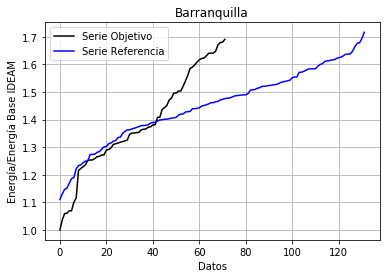

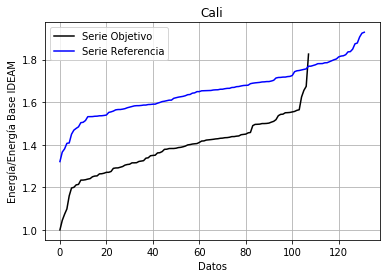

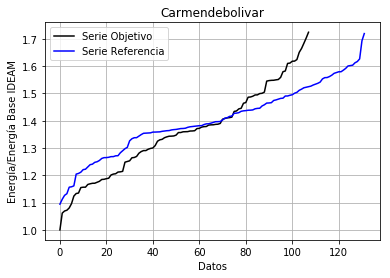

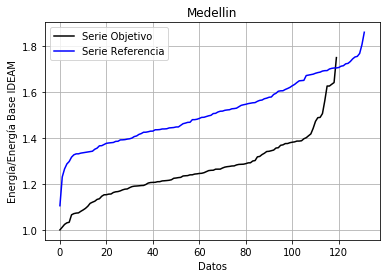

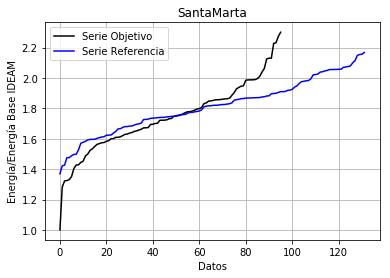

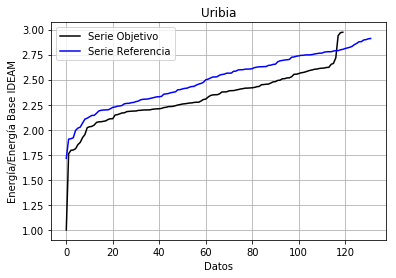

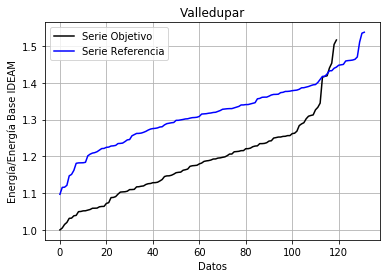

In [20]:
ciudades=["Barranquilla","Cali","Carmendebolivar","Medellin","SantaMarta","Uribia","Valledupar"]
for city in ciudades:
    PorCiudad(city,2005,2015,1,12,True)

3. Se tomara una ciudad de referencia y se vera los errores asociados a la corrección de la serie medida en tierra -comparandola con la serie satelital-  para estimar el tiempo necesario para una medida correcta. Adicionalmente se comararan diferentes años para ver cual habria sido el mejor año para tomar medidas en tierra.
***
Ciudad de estudio: **Medellin**
***
**Nota: Las graficas que se muestran a continuacion corresponden a: 1,3,6,12,24 meses desde el año inicial que se meustra en el comando incial** 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.66434312995
            Fecha Final RMSE [%]    MBE [%]  \
1    (2007, 1, 2007, 1)  16.2938    5.34469   
3    (2007, 1, 2007, 3)  16.1257    5.12223   
6    (2007, 1, 2007, 6)  14.2147    1.42713   
12  (2007, 1, 2007, 12)  14.0782  0.0452672   
24  (2007, 1, 2008, 12)  14.4691   -1.75683   

                          KSI[p-Value]  
1            (0.25, 0.000851098187747)  
3   (0.241666666667, 0.00141569840521)  
6     (0.116666666667, 0.366570200771)  
12   (0.0833333333333, 0.781593040441)  
24              (0.15, 0.122279187014)  


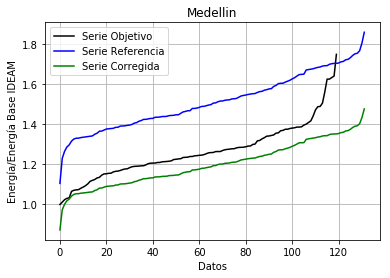

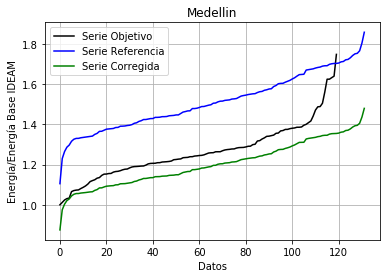

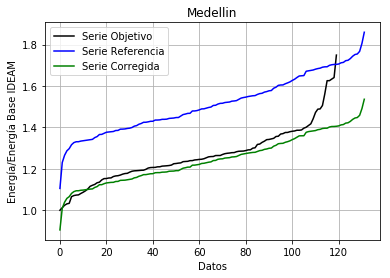

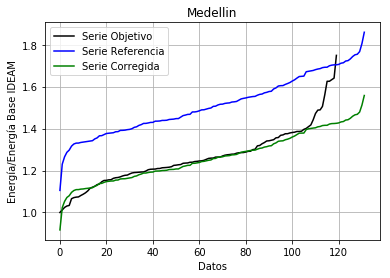

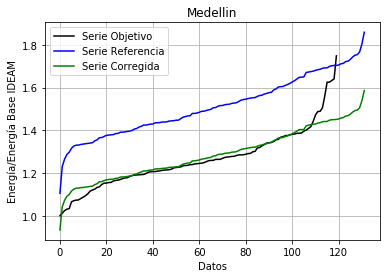

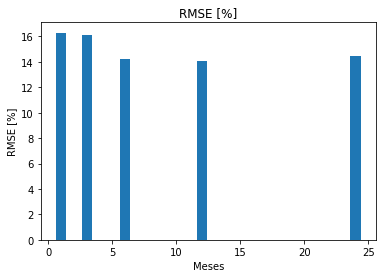

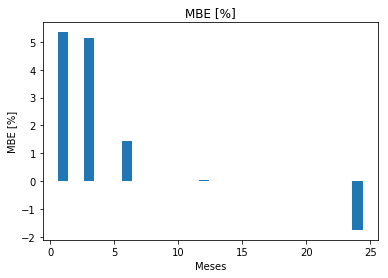

In [21]:
Estadisticas('Medellin',2007)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.66380660501
            Fecha Final RMSE [%]  MBE [%]                        KSI[p-Value]
1    (2008, 1, 2008, 1)  14.1697 -1.13007    (0.116666666667, 0.366570200771)
3    (2008, 1, 2008, 3)  15.5071 -3.57488  (0.208333333333, 0.00912058680232)
6    (2008, 1, 2008, 6)  16.0583 -4.19532    (0.233333333333, 0.002314571475)
12  (2008, 1, 2008, 12)  15.5638 -3.59535  (0.208333333333, 0.00912058680232)
24  (2008, 1, 2009, 12)  14.3951 -1.63838    (0.141666666667, 0.165311302375)


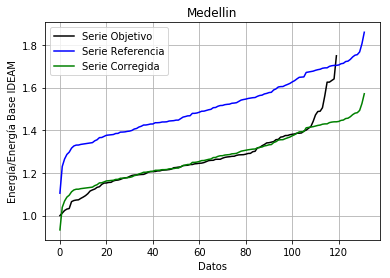

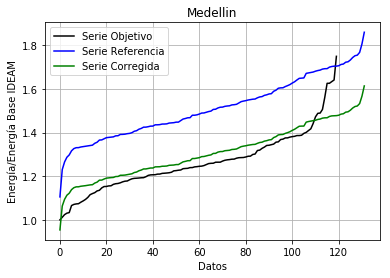

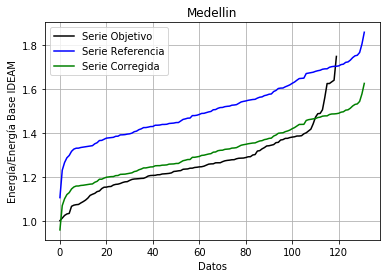

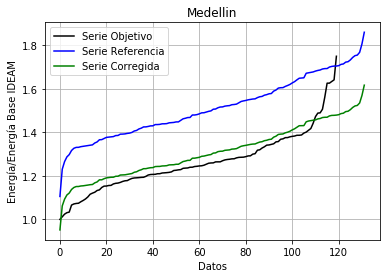

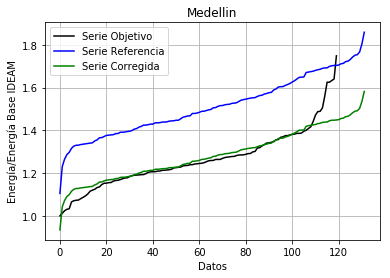

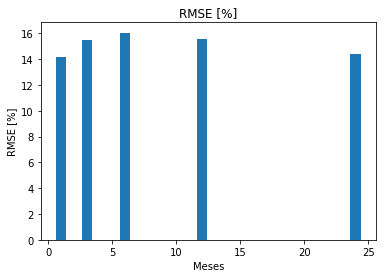

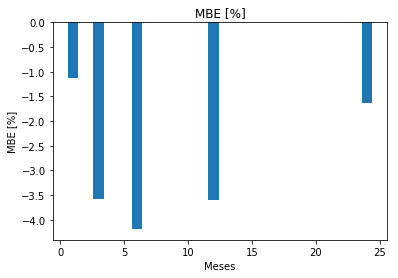

In [22]:
Estadisticas('Medellin',2008)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.57557301648
            Fecha Final RMSE [%]   MBE [%]  \
1    (2009, 1, 2009, 1)  14.0417  0.142216   
3    (2009, 1, 2009, 3)  16.7036  -4.88825   
6    (2009, 1, 2009, 6)  15.6357  -3.75534   
12  (2009, 1, 2009, 12)  14.0241   0.36711   
24  (2009, 1, 2010, 12)  14.0691  0.925475   

                           KSI[p-Value]  
1     (0.0833333333333, 0.781593040441)  
3   (0.258333333333, 0.000502918215243)  
6    (0.216666666667, 0.00587484788094)  
12              (0.075, 0.875954629946)  
24    (0.0833333333333, 0.781593040441)  


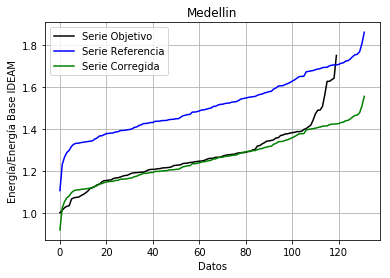

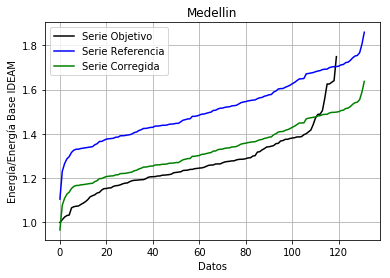

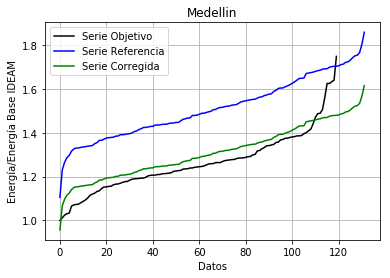

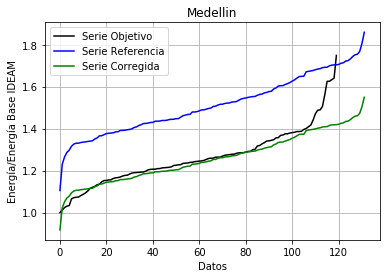

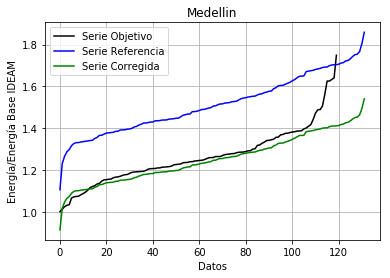

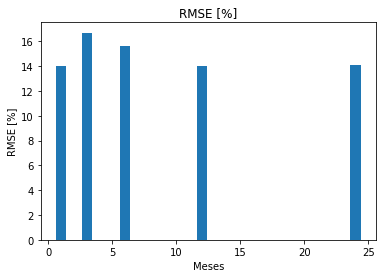

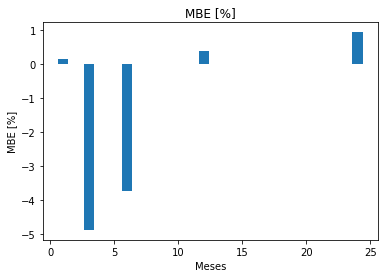

In [23]:
Estadisticas('Medellin',2009)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.54738564746
            Fecha Final RMSE [%]  MBE [%]                        KSI[p-Value]
1    (2010, 1, 2010, 1)  27.1736  16.1598  (0.566666666667, 9.5790518299e-18)
3    (2010, 1, 2010, 3)  20.5994  9.98347            (0.4, 4.68965777206e-09)
6    (2010, 1, 2010, 6)  15.1701  3.73209              (0.2, 0.0139173848978)
12  (2010, 1, 2010, 12)   14.172  1.47549    (0.116666666667, 0.366570200771)
24  (2010, 1, 2011, 12)  14.2423  1.64871    (0.133333333333, 0.219571571973)


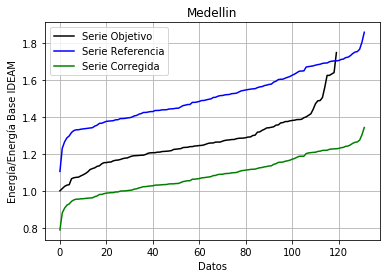

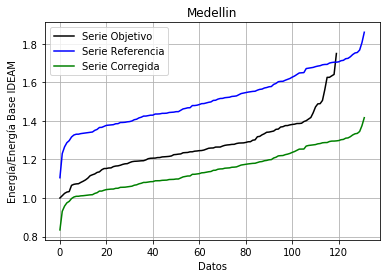

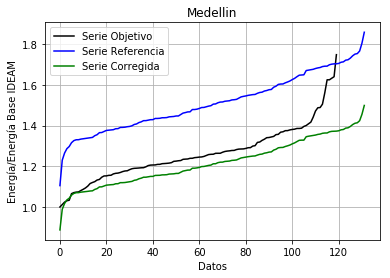

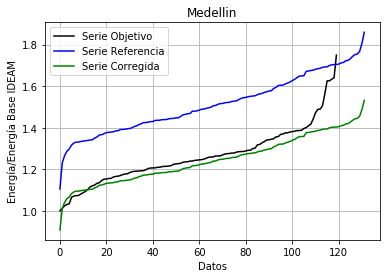

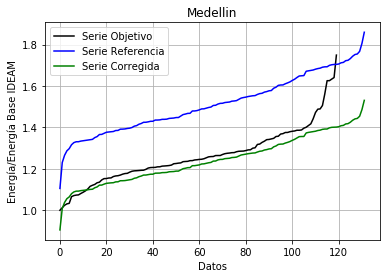

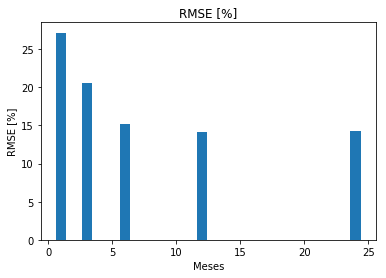

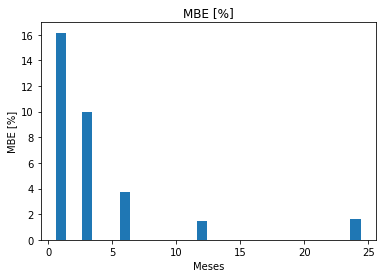

In [24]:
Estadisticas('Medellin',2010)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.5148391471
            Fecha Final RMSE [%]  MBE [%]                         KSI[p-Value]
1    (2011, 1, 2011, 1)  18.3044  7.68198  (0.333333333333, 2.03259864377e-06)
3    (2011, 1, 2011, 3)  18.4131  7.84922  (0.333333333333, 2.03259864377e-06)
6    (2011, 1, 2011, 6)  15.2853  3.96762               (0.2, 0.0139173848978)
12  (2011, 1, 2011, 12)  14.3181  1.82519     (0.141666666667, 0.165311302375)
24  (2011, 1, 2012, 12)  14.5457  2.42207               (0.15, 0.122279187014)


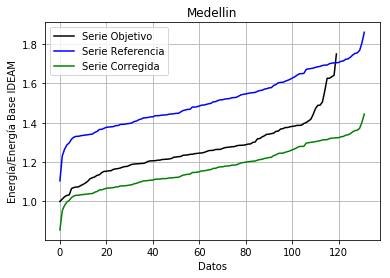

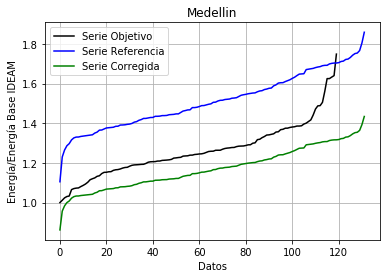

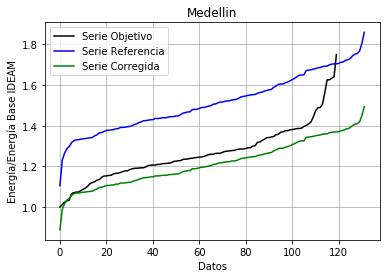

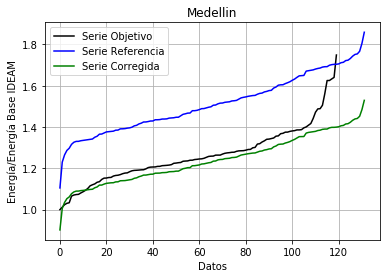

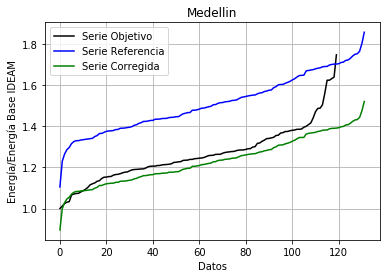

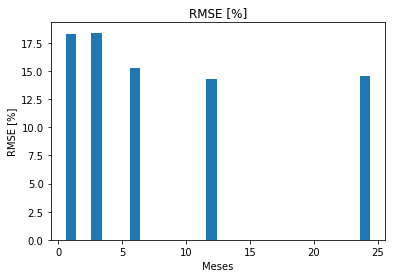

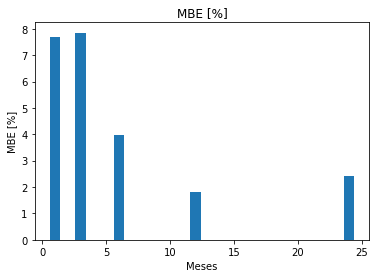

In [25]:
Estadisticas('Medellin',2011)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.53238245758
            Fecha Final RMSE [%]  MBE [%]                         KSI[p-Value]
1    (2012, 1, 2012, 1)  14.7224 -2.81591    (0.183333333333, 0.0307717686522)
3    (2012, 1, 2012, 3)  18.5348  7.96715  (0.341666666667, 1.01078107456e-06)
6    (2012, 1, 2012, 6)  18.5948  7.96335  (0.341666666667, 1.01078107456e-06)
12  (2012, 1, 2012, 12)  14.8233  3.00673             (0.175, 0.0445872330161)
24  (2012, 1, 2013, 12)  14.3486  1.79246     (0.141666666667, 0.165311302375)


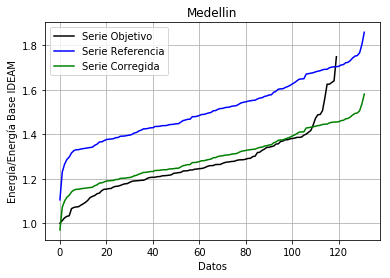

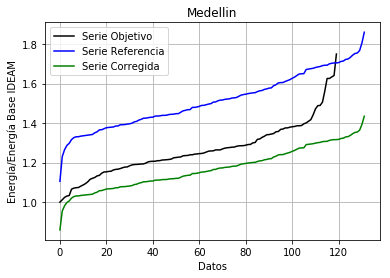

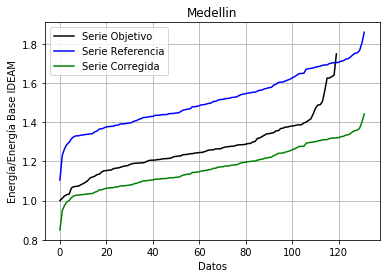

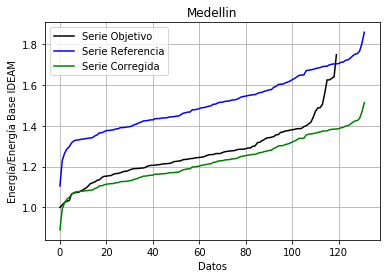

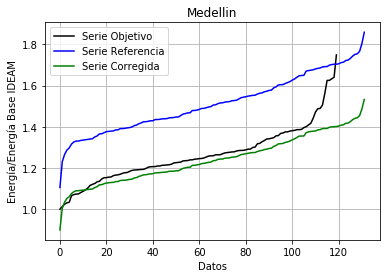

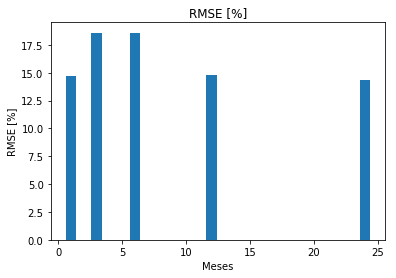

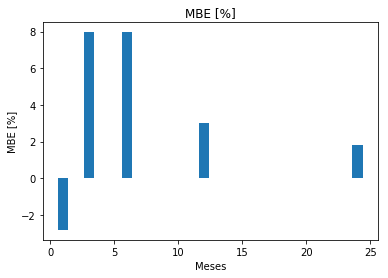

In [26]:
Estadisticas('Medellin',2012)

De todas las graficas presentadas anteriormente nos damos cuenta que con un año de medidas en terreno, y la correcta relación de datos 
se logra una gran estimacion del comportamiento a lo largo de 10 años.  
Para **Medellin** el mejor año para tomar datos fue el *2008*, mientras que el peor año fue el *2010*. Estos resultados se deben a que Colombia sufrio un cambio muy rapido entre los fenomenos del Niño y la Niña entre los años 2009 y 2010, ya que hubo periodos anormales de de lluvia y sol. Todo esto afecto, en el sentido de que no fue un periodo de condiciones normales. Por eso, las mediciones y correcciones en estos dos años no son adecuadas.



## 4. Visualizar los años 2008 y 2010 entre otras dos ciudades para comparar  
***

Ciudades a revisar: Cali y Valledupar

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 31.8355693269
EL MBE entre IDEAM y NREL es: -12.608555032995303
La ENFICC de la serie IDEAM  3.33077931605
La ENFICC de la serie NREL  4.36085916667
La ENFICC de la serie CORREGIDA  3.73530390815
            Fecha Final RMSE [%]   MBE [%]                       KSI[p-Value]
1    (2008, 1, 2008, 1)  10.1239 -0.762575    (0.12962962963, 0.303467201496)
3    (2008, 1, 2008, 3)  10.1194 -0.745777    (0.12962962963, 0.303467201496)
6    (2008, 1, 2008, 6)  10.2265  -1.12214   (0.138888888889, 0.230166953954)
12  (2008, 1, 2008, 12)   11.048   -2.6603  (0.203703703704, 0.0191688358984)
24  (2008, 1, 2009, 12)  10.8725  -2.41903  (0.175925925926, 0.0624499367622)


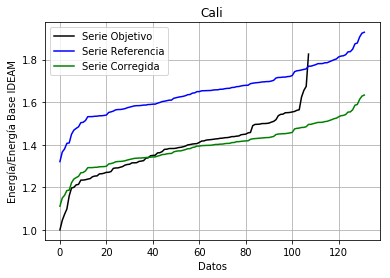

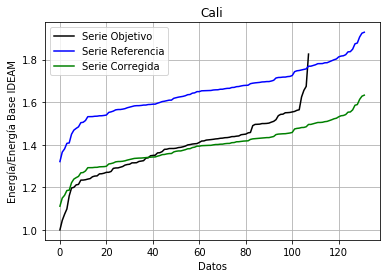

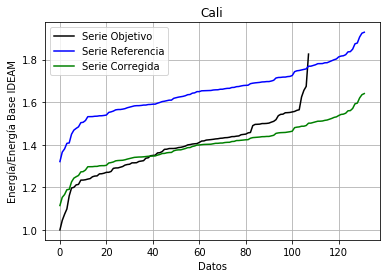

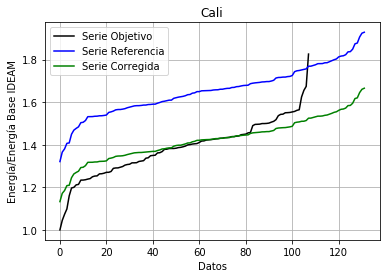

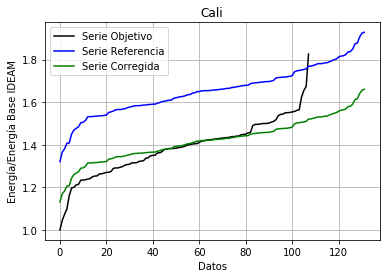

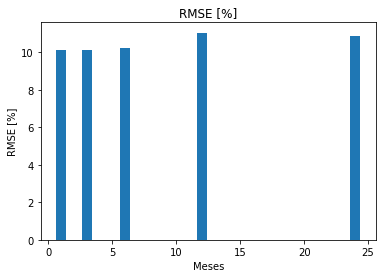

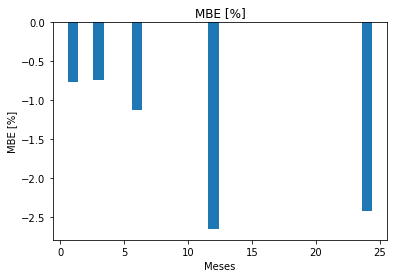

In [27]:
Estadisticas('Cali',2008)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 31.8355693269
EL MBE entre IDEAM y NREL es: -12.608555032995303
La ENFICC de la serie IDEAM  3.33077931605
La ENFICC de la serie NREL  4.36085916667
La ENFICC de la serie CORREGIDA  3.639737296
            Fecha Final RMSE [%]    MBE [%]                       KSI[p-Value]
1    (2010, 1, 2010, 1)  10.4189    1.70588  (0.175925925926, 0.0624499367622)
3    (2010, 1, 2010, 3)  10.0283  0.0362264   (0.101851851852, 0.606668396628)
6    (2010, 1, 2010, 6)  10.0532  -0.345336   (0.111111111111, 0.493853645281)
12  (2010, 1, 2010, 12)  10.0518  -0.268932   (0.101851851852, 0.606668396628)
24  (2010, 1, 2011, 12)  10.0409   0.100162   (0.101851851852, 0.606668396628)


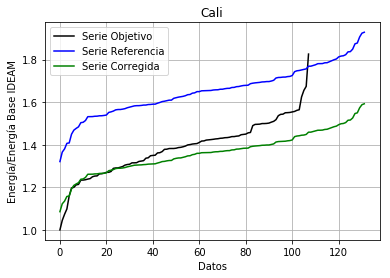

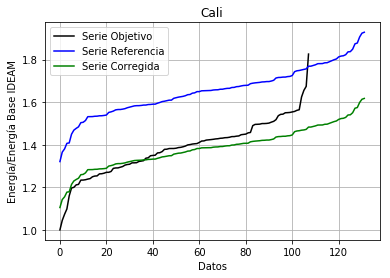

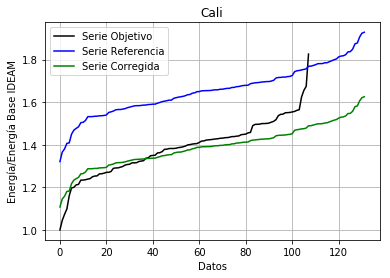

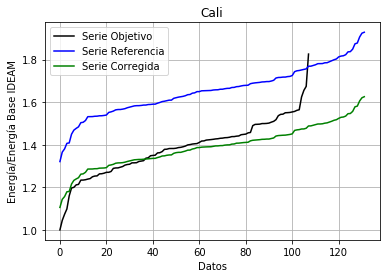

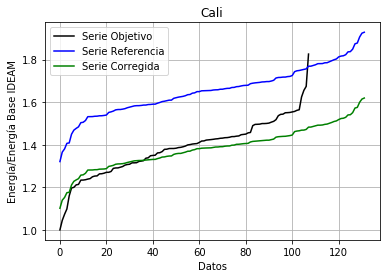

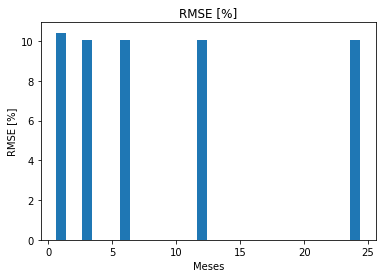

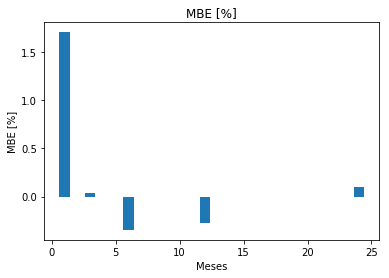

In [28]:
Estadisticas('Cali',2010)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 30.6477341498
EL MBE entre IDEAM y NREL es: -9.117161998892827
La ENFICC de la serie IDEAM  4.56900737661
La ENFICC de la serie NREL  5.06265316667
La ENFICC de la serie CORREGIDA  4.64242301116
            Fecha Final RMSE [%]   MBE [%]                        KSI[p-Value]
1    (2008, 1, 2008, 1)  17.1238  -2.75465  (0.216666666667, 0.00587484788094)
3    (2008, 1, 2008, 3)  15.8453  0.442834   (0.0916666666667, 0.673781227063)
6    (2008, 1, 2008, 6)  16.2216   -1.4742   (0.158333333333, 0.0888845174088)
12  (2008, 1, 2008, 12)  17.0472  -2.63556  (0.208333333333, 0.00912058680232)
24  (2008, 1, 2009, 12)  16.8757  -2.42568              (0.2, 0.0139173848978)


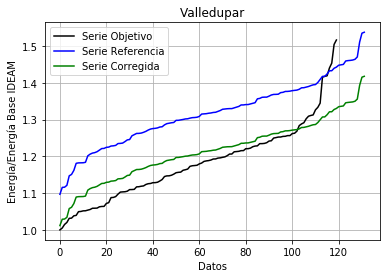

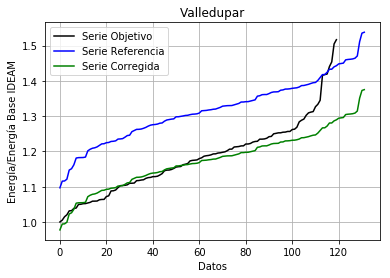

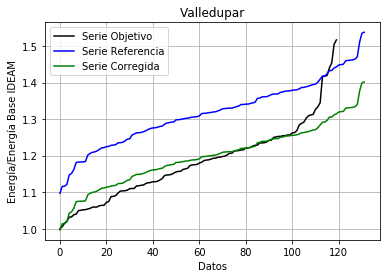

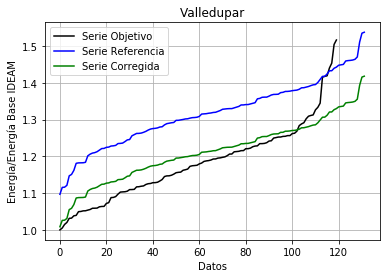

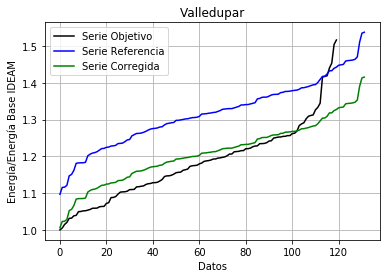

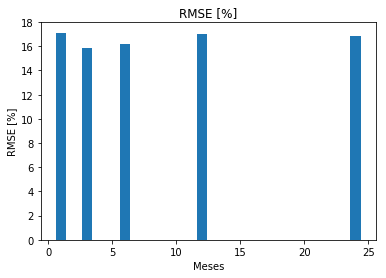

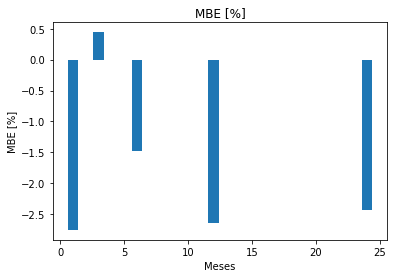

In [29]:
Estadisticas('Valledupar',2008)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 30.6477341498
EL MBE entre IDEAM y NREL es: -9.117161998892827
La ENFICC de la serie IDEAM  4.56900737661
La ENFICC de la serie NREL  5.06265316667
La ENFICC de la serie CORREGIDA  4.4798187135
            Fecha Final RMSE [%]   MBE [%]                       KSI[p-Value]
1    (2010, 1, 2010, 1)  15.8151 -0.228225            (0.125, 0.286403832382)
3    (2010, 1, 2010, 3)  16.4766   2.10702   (0.141666666667, 0.165311302375)
6    (2010, 1, 2010, 6)   16.216   1.60999            (0.125, 0.286403832382)
12  (2010, 1, 2010, 12)  16.0712   1.26898   (0.108333333333, 0.459738479705)
24  (2010, 1, 2011, 12)   15.981  0.985597  (0.0916666666667, 0.673781227063)


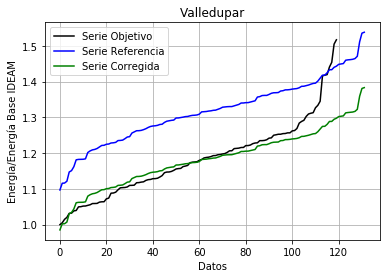

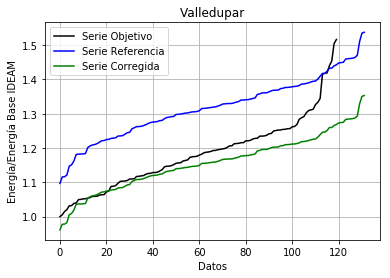

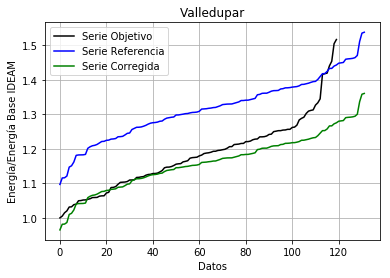

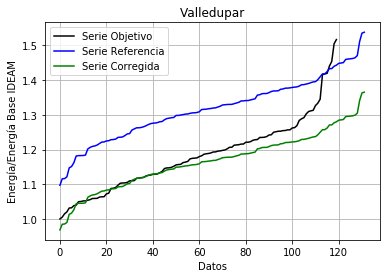

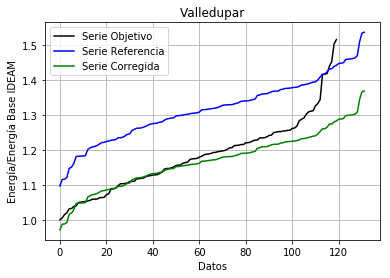

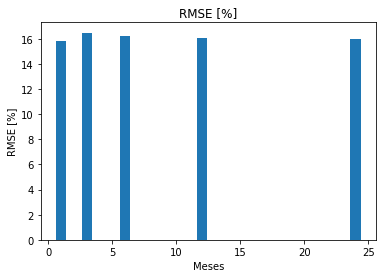

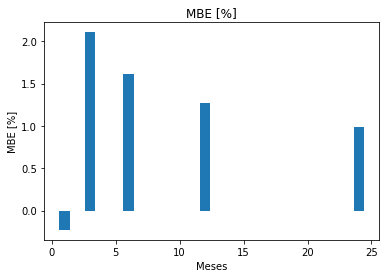

In [30]:
Estadisticas('Valledupar',2010)

Como nos podemos dar cuenta, en las ciudades de referencia no se mantiene, esto se puede deber a que Medellin se vio mas afectada por la toma de datos durante el 2010. 